## Generative Adversarial Net (GAN) PyTorch 구현: 손글씨 생성

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

일반적으로 신경망에 입력되는 데이터는 표준화해주면 좋습니다. 여기서의 정규화란 평균을 0으로, 표준편차를 1로 만들어주는 것을 뜻합니다. 위 데이터는 픽셀값이 각각 0에서 1에 바운딩되므로, 평균을 대략 0.5로 잡고 표준편차를 0.5로 잡아서 정규화해보겠습니다. 사실 이 과정은 꽤 손이 많이가는 전처리 과정이나, PyTorch 라이브러리를 사용하면 간단하게 해결 가능합니다. 코드를 보시겠습니다.

 transforms 패키지에는 다양한 image transformation 기능이 있습니다. 여러개의 transformation기능을 한번에 사용하고 싶은 경우 위처럼 Compose메서드를 이용해 chain 시킬 수 있습니다.

chain된 transformation은 ToTensor와 Normalize입니다. ToTensor는 데이터의 형식이 PIL Image 또는 Numpy.ndarray일 경우 텐서로 변환해 주는 기능입니다. 더 자세하게는 [0, 255]사이의 정수값을 가지는 (높이, 넓이, 채널) 차원의 이미지를 [0.0, 1.0]사이의 실수값을 가지는 (채널, 높이, 넓이)차원의 텐서로 변환시킵니다.

 Normalize는 텐서 이미지를 각 채널마다 설정한 평균, 표준편차로 정규화해주는 작업입니다. 예를 들어 위처럼 (m1, m2, m3), (s1, s2, s3)를 인자로 받을 경우 각 채널에 대해 아래와 같은 식으로 이미지를 정규화 합니다.

$output\left[channel\right]\ =\ \left(input\left[channel\right]-m\left[channel\right]\right)\div s\left[channel\right]$output[channel] = (input[channel]−m[channel])÷s[channel]​
[출처] 파이토치 튜토리얼 4 (PyTorch Tutorial 4)|작성자 횬초리

In [9]:
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5,),   # 3 for RGB channels이나 실제론 gray scale
                                         std=(0.5,))])  # 3 for RGB channels이나 실제론 gray scale
# MNIST dataset
train_data = dsets.MNIST(root='data/', train=True, transform=standardizator, download=True)
test_data  = dsets.MNIST(root='data/', train=False, transform=standardizator, download=True)


batch_size = 200
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)
l=next(iter(train_data_loader))
print(l[0].shape)
print(l[1].shape)

torch.Size([200, 1, 28, 28])
torch.Size([200])


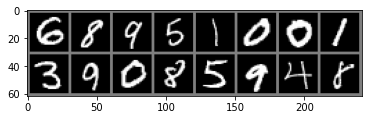

In [10]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    ## -1부터 1까지범위로 표준화했으므로 0~1로 바꿔주기 위해서
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0))) #1x28x28을 28x28x1로 바꿔줌
    plt.show()
    
example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

# GAN 구현하기
아주 간단한 MLP(Multi-Layer Perceptron)으로 Generator G를 구현해보겠습니다.

G는 100차원의 가우시안 디스트리뷰션에서 샘플링한 노이즈 z를 이용하여 MNIST 데이터를 만들어내는 MLP입니다.

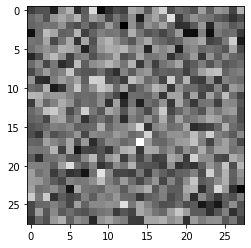

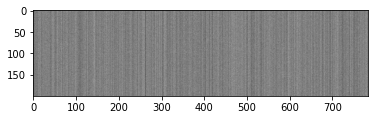

In [11]:
d_noise  = 100
d_hidden = 256
def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)
G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)
# 노이즈 생성하기
z = sample_z()
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)

In [12]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
).to(device)
print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.5045, 0.4969, 0.4991, 0.4996, 0.4989]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [13]:
criterion = nn.BCELoss()
def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    
    generator.train() #train으로 모드 변경
    discriminator.train() #train으로 모드 변경

    for img_batch, label_batch in train_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d    = (loss_real + loss_fake).mean()
        
        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #
        
        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))
                
        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        
        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean() 

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()
   
        # Update parameters
        _optimizer_g.step()
          
def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for img_batch, label_batch in test_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.
            
            
    return p_real, p_fake

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
(epoch 50/200) p_real: 0.740519, p_g: 0.246672


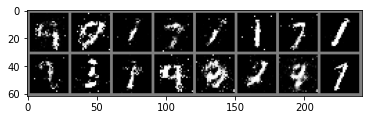

50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
(epoch 100/200) p_real: 0.633159, p_g: 0.290784


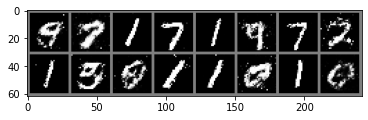

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
(epoch 150/200) p_real: 0.637219, p_g: 0.366088


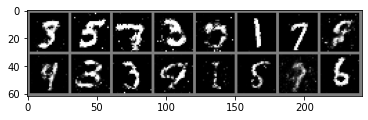

150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
(epoch 200/200) p_real: 0.610495, p_g: 0.300247


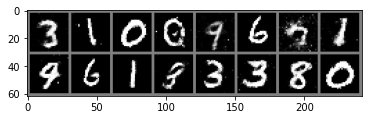

In [14]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):
  print(epoch)
  run_epoch(G, D, optimizer_g, optimizer_d)
  p_real, p_fake = evaluate_model(G,D)

  p_real_trace.append(p_real)
  p_fake_trace.append(p_fake) 

  if((epoch+1)% 50 == 0):
      print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
      imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

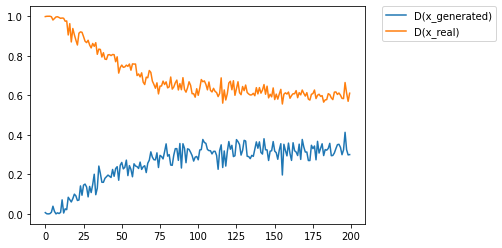

In [15]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

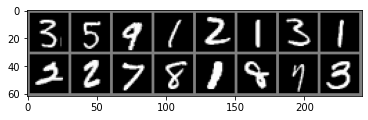

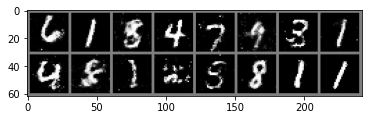

In [16]:
vis_loader = torch.utils.data.DataLoader(test_data, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

imshow_grid(G(sample_z(16,100)).view(-1, 1, 28, 28))